### Imports


In [1]:
# general
import os
import glob
import datetime as dt
import json
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, simple_sounding, mean_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()
# run nc deep_clean
import nctoolkit as nc
nc.deep_clean()

nctoolkit is using Climate Data Operators version 2.4.4


In [2]:
# Function to load ARM credentials
def load_arm_credentials(credential_path):
    with open(credential_path, 'r') as f:
        credentials = json.load(f)
    return credentials
# Location of ARM credentials
credential_path = '/home/dlhogan/.act_config.json'
credentials = load_arm_credentials(credential_path)
# api token and username for ARM
api_username = credentials.get('username')
api_token = credentials.get('token')

sail_datastream_dict = {
    "tropoe":"guctropoeM1.c1"
}

In [3]:
winter_22 = ('20211201','20220401')
winter_23 = ('20221201','20230401')

In [4]:
# Set the location of the data folder where this data will be stored
winter_22_folder = 'winter_21_22'
winter_23_folder = 'winter_22_23'
 # change to location of data folder on your machine
storage_directory = f'/storage/dlhogan/synoptic_sublimation/'
# create a sail_data folder if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data')):
    os.makedirs(os.path.join(storage_directory,'sail_data'))
# create a folder for the event if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_22_folder)):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_22_folder))
# create a folder for the event if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_23_folder)):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_23_folder))
    # make a radiosonde folder if it does not exist

In [5]:
# load in the winter 22 data
sail_winter_22_folder = os.path.join(storage_directory,'sail_data',winter_22_folder)
# create empty data dictionary
w22_data_loc_dict = {}
# Iterate through the dictionary and pull the data for each datastream
for k,v in sail_datastream_dict.items():

    if (os.path.exists(f'{sail_winter_22_folder}/{k}_{winter_22[0]}_{winter_22[1]}.nc')): 
        print(f'{k}_{winter_22[0]}_{winter_22[1]}.nc already exists')
        print('-------------------')
        # add the filename to the dictionary which can be used if we want to load the data
        w22_data_loc_dict[k] = os.path.join(sail_winter_22_folder,f'{k}_{winter_22[0]}_{winter_22[1]}.nc')
        continue
    else:
        # explicitly download radiosonde data because they are a lot easier to process and think about when in individual files
        ds = get_sail_data(api_username,
                        api_token,
                        v,
                        startdate=winter_22[0],
                        enddate=winter_22[1])
        ds.to_netcdf(f'{sail_winter_22_folder}/{k}_{winter_22[0]}_{winter_22[1]}.nc')
        w22_data_loc_dict[k] = os.path.join(sail_winter_22_folder,f'{k}_{winter_22[0]}_{winter_22[1]}.nc')

tropoe_20211201_20220401.nc already exists
-------------------


In [6]:
# open the data
tropoe_w22 = xr.open_dataset(w22_data_loc_dict['tropoe'])

In [7]:
# load in the winter 23 data
sail_winter_23_folder = os.path.join(storage_directory,'sail_data',winter_23_folder)
# create empty data dictionary
w23_data_loc_dict = {}
# Iterate through the dictionary and pull the data for each datastream
for k,v in sail_datastream_dict.items():

    if (os.path.exists(f'{sail_winter_23_folder}/{k}_{winter_23[0]}_{winter_23[1]}.nc')): 
        print(f'{k}_{winter_23[0]}_{winter_23[1]}.nc already exists')
        print('-------------------')
        # add the filename to the dictionary which can be used if we want to load the data
        w23_data_loc_dict[k] = os.path.join(sail_winter_23_folder,f'{k}_{winter_23[0]}_{winter_23[1]}.nc')
        continue
    else:
        # explicitly download radiosonde data because they are a lot easier to process and think about when in individual files
        ds = get_sail_data(api_username,
                        api_token,
                        v,
                        startdate=winter_23[0],
                        enddate=winter_23[1])
        ds.to_netcdf(f'{sail_winter_23_folder}/{k}_{winter_23[0]}_{winter_23[1]}.nc')
        w23_data_loc_dict[k] = os.path.join(sail_winter_23_folder,f'{k}_{winter_23[0]}_{winter_23[1]}.nc')

tropoe_20221201_20230401.nc already exists
-------------------


In [8]:
w23_tropoe_ds = xr.open_dataset(w23_data_loc_dict['tropoe'])
subset_ds = w23_tropoe_ds.sel(time=slice('2023-03-03','2023-03-09'), height=slice(0,3)).resample(time='3H').mean()

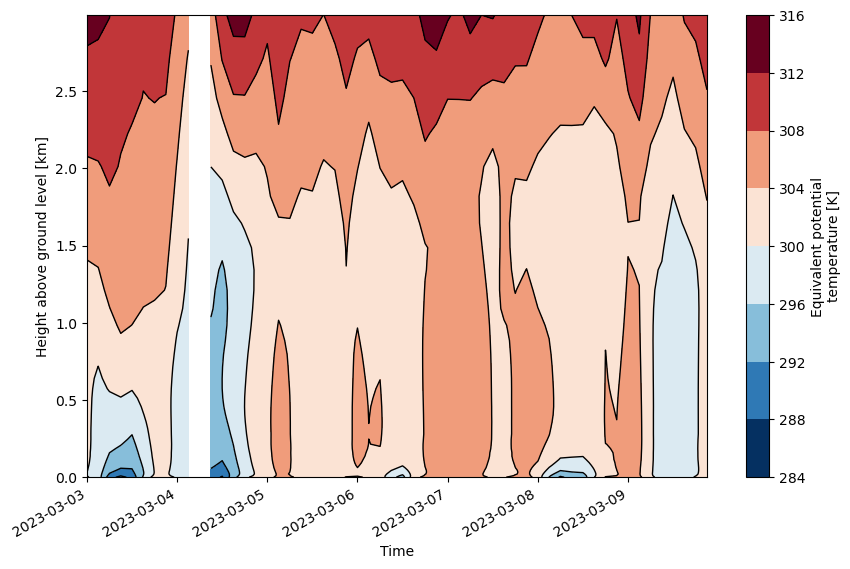

In [9]:

# set up a contour plot of the data using contour and contourf
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# plot the data
subset_ds['thetae'].plot.contourf(x='time',ax=ax, levels=10, cmap='RdBu_r')
subset_ds['thetae'].plot.contour(x='time',ax=ax, levels=10, colors='k', linewidths=1, linestyles='-')

In [10]:
sbih_3H = w23_tropoe_ds['sbih'].where(w23_tropoe_ds['sbih']>0, np.nan).resample(time='3H').mean()

In [11]:
large_sub_events = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_long_events.csv', index_col=0, parse_dates=True)

In [12]:
# get the 

In [13]:
large_events = sbih_3H.where((sbih_3H.time.isin(large_sub_events.index)))
all_events = sbih_3H

In [14]:
all_events

<xarray.DataArray 'sbih' (time: 967)>
array([0.28149998, 0.26486108, 0.21772222, 0.23763888, 0.32597223,
       0.31377777,        nan, 0.15133333, 0.10863637, 0.080125  ,
       0.077     ,        nan,        nan,        nan,        nan,
              nan,        nan, 0.17442857, 0.24686109, 0.29519442,
       0.294625  ,        nan, 1.819     ,        nan, 0.26933333,
       0.22500001, 0.25038463, 0.245     , 0.24499999, 0.25038463,
              nan, 0.12266666, 0.15040001, 0.11957143,        nan,
       0.083     ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.033     ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.046     , 0.12740001, 0.24668749,
       0.3243333 , 0.41224998, 0.50027776, 0.46233332, 0.41009092,
              nan, 0.12525   , 0.15487094, 0.20374285, 0.3159167 ,
       0.42150003, 0.5244722 , 0.4574286 ,        nan, 0.21440001,
       0.29254285, 0.32255554, 0.34775004, 0.3756111 , 0.3785833 ,
       0.318     ,        nan, 0.16694736, 0.22940001, 0.19709091,
       0.18762068, 0.095     ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
...
              nan,        nan, 0.15399998, 0.1861389 , 0.19208334,
       0.17526667,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.114     , 0.18248   ,
              nan,        nan,        nan,        nan,        nan,
       0.114     ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.12411112, 0.1519091 ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.114     ,        nan,        nan,
              nan,        nan, 0.20058335, 0.2453333 , 0.168     ,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.214     ,        nan,        nan,
              nan, 0.12760001, 0.20845716, 0.40591666, 0.9353334 ,
       0.9563888 , 0.795     ,        nan, 0.12025   , 0.11920001,
       0.17700002, 0.2238889 , 0.26947218, 0.2848276 , 0.17199999,
              nan,        nan, 0.20617644, 0.23908332, 0.21519445,
       0.21586113, 0.17325   ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01 ... 2023-03-31T18:00:00
Attributes:
    long_name:  Surface-based inversion height
    units:      km
    comment1:   This field is derived from the retrieved fields
    comment2:   A value of -999 indicates that this field could not be comput...

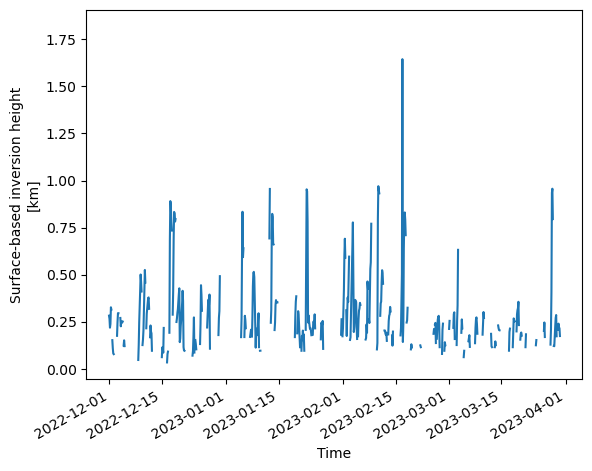

In [15]:
all_events.plot()

In [16]:
fig = plt.figure(figsize=(10,6))
# create boxplot of inversion height for large_events and all_events
import seaborn as sns
sns.boxplot(data=[large_events, all_events], ax=ax)

<Axes: xlabel='Time', ylabel='Height above ground level [km]'>

<Figure size 1000x600 with 0 Axes>